# Default Parameters

In [ ]:
filename = "bank-full.csv"
target_variable_name = "y"

# Load Dataset

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

In [ ]:
from pyspark.sql import functions as F

df = df.withColumn('label', F.when(F.col("y") == 'yes', 1).otherwise(0))
df = df.drop('y')

# Simple Random sampling

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [ ]:
for k, v in df.dtypes:
    if v not in ['string']:
        print(k)

In [ ]:
df = df.select(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'label'])

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [ ]:
#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove('label')

In [ ]:
# apply the function on our dataframe
assembled_df = assemble_vectors(train, features_list, 'label')

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()
train_valid_clf = TrainValidationSplit(estimator=lr, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(),
                           # 70% of the data will be used for training, 30% for validation.
                           trainRatio=0.7)
model = train_valid_clf.fit(assembled_df)

# Stratified Sampling

In [ ]:
# split data for 0s and 1s
zero_df = df.filter(df["label"]==0)
one_df = df.filter(df["label"]==1)

# split data into train and test
train_zero, test_zero = zero_df.randomSplit([0.7,0.3], seed=12345)
train_one, test_one = one_df.randomSplit([0.7,0.3], seed=12345)

# union datasets
train = train_zero.union(train_one)
test = test_zero.union(test_one)

# Holdout

In [ ]:
train, test, holdout = df.randomSplit([0.7, 0.2, 0.1], seed=12345)

In [ ]:
train.count(), test.count(), holdout.count()

$$PSI=\sum (Actual \% - Expected\%) * ln( \frac{Actual\%}{Expected\%})$$

# k-fold cross validation

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#model initialization
lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')

#model parameters to try
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

# number of folds = 3
crossval_clf = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                                 evaluator=BinaryClassificationEvaluator(), numFolds=3, )

# assembled_df is the output of the vector assembler
model = crossval_clf.fit(assembled_df)

# Leave-one-group out cross validation

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import countDistinct
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import numpy as np

filename = "bank-full.csv"
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df = df.withColumn('label', F.when(F.col("y") == 'yes', 1).otherwise(0))
df = df.drop('y')
df = df.select(['education', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'label'])
features_list = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'] 

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name, group_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [group_variable_name, target_variable_name, 'features']

    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

# apply the function on our dataframe
joined_df = assemble_vectors(df, features_list, 'label', 'education')
groups = list(joined_df.select('education').toPandas()['education'].unique())

# leave one group out validation 
def leave_one_group_out_validator(df, var_name, groups):
    
    train_metric_score = []
    test_metric_score = []
    
    for i in groups:
        train = df.filter(df[var_name]!=i)
        test = df.filter(df[var_name]==i)
    
        #model initialization
        lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')
        evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', 
                                                  metricName='areaUnderROC')
        #fit model
        lrModel = lr.fit(train)

        #make predicitons
        predict_train = lrModel.transform(train)
        predict_test = lrModel.transform(test)
        
        train_metric_score.append(evaluator.evaluate(predict_train))
        test_metric_score.append(evaluator.evaluate(predict_test))
        print(str(i) + " Group evaluation")
        print(" Train AUC - ", train_metric_score[-1])
        print(" Test AUC - ", test_metric_score[-1])
        
    print('Final evaluation for model')
    print('Train ROC', np.mean(train_metric_score))
    print('Test ROC', np.mean(test_metric_score))

In [ ]:
leave_one_group_out_validator(joined_df, 'education', groups)

# Regression models

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StructField, StructType

cSchema = StructType([StructField("x1", IntegerType())\
                      ,StructField("x2", IntegerType())\
                      ,StructField("y", IntegerType())])

df_list = [[58, 50, 12], [37, 95, 27], [29, 137, 39], [19, 150, 45]]


df = spark.createDataFrame(df_list, schema=cSchema)
df.show()

In [ ]:
assembled_df = assemble_vectors(df, ['x1'], 'y')

In [ ]:
from pyspark.ml.regression import LinearRegression

reg = LinearRegression(featuresCol='features', labelCol='y')

In [ ]:
reg_model = reg.fit(assembled_df)

In [ ]:
print(reg_model.coefficients[0], reg_model.intercept)

In [ ]:
pred_result = reg_model.transform(assembled_df)

In [ ]:
reg_summary = reg_model.summary

print('Mean Squared error', reg_summary.meanSquaredError)
print('Root mean squared error', reg_summary.rootMeanSquaredError)
print('Mean Absolute error', reg_summary.meanAbsoluteError)
print('Explained Variance', reg_summary.explainedVariance)
print('R squared', reg_summary.r2)

# Mean square error

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='y', predictionCol='prediction', metricName='mse')

In [ ]:
evaluator.evaluate(pred_result)

# Root Mean Square error

In [ ]:
evaluator = RegressionEvaluator(labelCol='y', predictionCol='prediction', metricName='rmse')
evaluator.evaluate(pred_result)

# Mean absolute error

In [ ]:
evaluator = RegressionEvaluator(labelCol='y', predictionCol='prediction', metricName='mae')
evaluator.evaluate(pred_result)

# Explained Variance

In [ ]:
# option available for Pyspark 3.0 and above
evaluator = RegressionEvaluator(labelCol='y', predictionCol='prediction', metricName='var')
evaluator.evaluate(pred_result)

In [ ]:
# PySpark < 3.0
print('Explained Variance', reg_summary.explainedVariance)

In [ ]:
1 - 4

# R- Squared

In [ ]:
1 - (3.303/159.19)

In [ ]:
evaluator = RegressionEvaluator(labelCol='y', predictionCol='prediction', metricName='r2')
evaluator.evaluate(pred_result)
print('R squared', reg_summary.r2)

# Adjusted R squared

In [ ]:
print('R squared', reg_summary.r2adj)

In [ ]:
1 - (((1-0.97924)*3)/(4-1-1))

In [ ]:
(12 + 27 + 39 + 45)/4

# Binary Classification

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.types import StructField, StructType

cSchema = StructType([StructField("x1", IntegerType())\
                      ,StructField("x2", IntegerType())\
                      ,StructField("target", IntegerType())])

df_list = [[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]


df = spark.createDataFrame(df_list, schema=cSchema)
df.show()

assembled_df = assemble_vectors(df, ['x1'], 'target')

from pyspark.ml.classification import LogisticRegression

clf = LogisticRegression(featuresCol='features', labelCol='target')

clf_model = clf.fit(assembled_df)

print(clf_model.coefficients[0], clf_model.intercept)

pred_result = clf_model.transform(assembled_df)

In [ ]:
pred_result.show()

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

predictionAndTarget = pred_result.select("prediction", "target")
predictionAndTarget = predictionAndTarget.withColumn("target", predictionAndTarget["target"].cast(DoubleType()))
predictionAndTarget = predictionAndTarget.withColumn("prediction", predictionAndTarget["prediction"].cast(DoubleType()))

metrics = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

In [ ]:
# confusion matrix
cm = metrics.confusionMatrix().toArray()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix_chart(cf_matrix):
    
    list_values = ['0', '1']

    plt.subplot(111)
    sns.heatmap(cf_matrix, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('OR Logic Gate predictions')

    plt.tight_layout()
    return None

In [ ]:
make_confusion_matrix_chart(cm)

$$Sigmoid\ function,\ Probability=(\frac{1}{1 + exp(-x)})$$

$$Accuracy=(\frac{TP + TN}{TP + TN + FP + FN})$$

$$Precision=(\frac{TP}{TP + FP})$$

$$Recall=(\frac{TP}{TP + FN})$$

$$F1-score=2*(\frac{Precision*Recall}{Precision + Recall})$$

$$Specificity=(\frac{TN}{TN + FP})=1- FPR$$

$$False\ Positive\ Rate=(\frac{FP}{FP + TN})$$

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
acc = metrics.accuracy
misclassification_rate = 1 - acc
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1 = metrics.fMeasure(1.0)
evaluator = BinaryClassificationEvaluator(labelCol='target', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
roc = evaluator.evaluate(pred_result)

In [ ]:
print(acc, misclassification_rate, precision, recall, f1, roc)

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        results_collect = rdd.collect()
        for row in results_collect:
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [ ]:
preds = pred_result.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))

# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds).get_curve('roc')

In [ ]:
import matplotlib.pyplot as plt
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(x_val, y_val, label = 'AUC = %0.2f' % roc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend(loc = 'lower right')

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='target', rawPredictionCol='rawPrediction', metricName='areaUnderPR')
pr = evaluator.evaluate(pred_result)

In [ ]:
pr

In [ ]:
preds = pred_result.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val, label = 'Average Precision = %0.2f' % pr)
plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--')
plt.legend(loc = 'lower right')

# Random Value

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# random target and probabilities
rand_y = [random.choice([1, 0]) for i in range(0, 100)]
rand_prob = [random.uniform(0, 1) for i in range(0, 100)]
rand_precision, rand_recall, _ = precision_recall_curve(rand_y, rand_prob)
pr = average_precision_score(rand_y, rand_prob)
#plot random predictions
plt.figure()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(rand_recall, rand_precision, label = 'Average Precision = %0.2f' % pr)
plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--')
plt.legend(loc = 'lower right')

# KS Statistic

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import countDistinct
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import numpy as np

filename = "bank-full.csv"
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df = df.withColumn('label', F.when(F.col("y") == 'yes', 1).otherwise(0))
df = df.drop('y')
#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

df = df.select(['education', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'label'])
features_list = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'] 
assembled_df = assemble_vectors(df, features_list, 'label')
clf = LogisticRegression(featuresCol='features', labelCol='label')
train, test = assembled_df.randomSplit([0.7, 0.3], seed=12345)
clf_model = clf.fit(train)

In [2]:
from pyspark.sql import Window

def create_deciles(df, clf, score, prediction, target, buckets):
    
    # get predictions from model
    pred = clf.transform(df)
    #probability of 1's, prediction and target
    pred = pred.select(F.col(score), F.col(prediction), F.col(target)).rdd.map(lambda row: (float(row[score][1]), float(row['prediction']), float(row[target])))
    predDF = pred.toDF(schema=[score, prediction, target])
    # remove ties in scores work around
    window = Window.orderBy(F.desc(score))
    predDF = predDF.withColumn("row_number", F.row_number().over(window))
    predDF.cache()
    predDF = predDF.withColumn("row_number", predDF['row_number'].cast("double"))
    # partition into 10 buckets
    window2 = Window.orderBy("row_number")
    final_predDF = predDF.withColumn("deciles", F.ntile(buckets).over(window2))
    final_predDF = final_predDF.withColumn("deciles", final_predDF['deciles'].cast("int"))
    # create non target column
    final_predDF = final_predDF.withColumn("non_target", 1 - final_predDF[target])
    final_predDF.cache()    #final predicted df
    
    #ks calculation starts here
    temp_deciles = final_predDF.groupby('deciles').agg(F.sum(target).alias(target)).toPandas()
    non_target_cnt = final_predDF.groupby('deciles').agg(F.sum('non_target').alias('non_target')).toPandas()
    temp_deciles = temp_deciles.merge(non_target_cnt, on='deciles', how='inner')
    temp_deciles = temp_deciles.sort_values(by='deciles', ascending=True)
    temp_deciles['total'] = temp_deciles[target] + temp_deciles['non_target']
    temp_deciles['target_%'] = (temp_deciles[target] / temp_deciles['total'])*100
    temp_deciles['cum_target'] = temp_deciles[target].cumsum()
    temp_deciles['cum_non_target'] = temp_deciles['non_target'].cumsum()
    temp_deciles['target_dist'] = (temp_deciles['cum_target']/temp_deciles[target].sum())*100
    temp_deciles['non_target_dist'] = (temp_deciles['cum_non_target']/temp_deciles['non_target'].sum())*100
    temp_deciles['spread'] = temp_deciles['target_dist'] - temp_deciles['non_target_dist']
    decile_table=temp_deciles.round(2)
    decile_table = decile_table[['deciles', 'total', 'label', 'non_target', 'target_%', 'cum_target', 'cum_non_target', 'target_dist', 'non_target_dist', 'spread']]
    print("KS Value - ", round(temp_deciles['spread'].max(), 2))
    return final_predDF, decile_table

In [3]:
pred_train, train_deciles = create_deciles(train, clf_model, 'probability', 'prediction', 'label', 10)
pred_test, test_deciles = create_deciles(test, clf_model, 'probability', 'prediction', 'label', 10)

KS Value -  50.28
KS Value -  49.63


In [4]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1, target, color='skyblue'):
    agg1 = agg1.round(2)
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['spread']).set_precision(2)
    agg1.bar(subset=[target], color='{}'.format(color), vmin=0)
    agg1.bar(subset=['total'], color='{}'.format(color), vmin=0)
    agg1.bar(subset=['target_%'], color='{}'.format(color), vmin=0)
    return agg1

In [5]:
plot_decile_train = decile_labels(train_deciles, 'label', color='skyblue')
plot_pandas_style(plot_decile_train)

,deciles,total,label,non_target,target_%,cum_target,cum_non_target,target_dist,non_target_dist,spread
0,1,3146.00,1497.00,1649.00,47.58,1497.00,1649.00,40.40,5.94,34.46
1,2,3146.00,760.00,2386.00,24.16,2257.00,4035.00,60.92,14.54,46.38
2,3,3146.00,498.00,2648.00,15.83,2755.00,6683.00,74.36,24.08,50.28
3,4,3146.00,326.00,2820.00,10.36,3081.00,9503.00,83.16,34.24,48.92
4,5,3146.00,269.00,2877.00,8.55,3350.00,12380.00,90.42,44.61,45.81
5,6,3146.00,157.00,2989.00,4.99,3507.00,15369.00,94.66,55.38,39.28
6,7,3146.00,96.00,3050.00,3.05,3603.00,18419.00,97.25,66.37,30.88
7,8,3145.00,52.00,3093.00,1.65,3655.00,21512.00,98.65,77.52,21.14
8,9,3145.00,35.00,3110.00,1.11,3690.00,24622.00,99.60,88.72,10.87
9,10,3145.00,15.00,3130.00,0.48,3705.00,27752.00,100.00,100.00,0.00


In [6]:
plot_decile_test = decile_labels(test_deciles, 'label', color='skyblue')
plot_pandas_style(plot_decile_test)

,deciles,total,label,non_target,target_%,cum_target,cum_non_target,target_dist,non_target_dist,spread
0,1,1376.00,621.00,755.00,45.13,621.00,755.00,39.20,6.20,33.00
1,2,1376.00,339.00,1037.00,24.64,960.00,1792.00,60.61,14.72,45.88
2,3,1376.00,211.00,1165.00,15.33,1171.00,2957.00,73.93,24.30,49.63
3,4,1376.00,155.00,1221.00,11.26,1326.00,4178.00,83.71,34.33,49.38
4,5,1375.00,89.00,1286.00,6.47,1415.00,5464.00,89.33,44.90,44.43
5,6,1375.00,68.00,1307.00,4.95,1483.00,6771.00,93.62,55.64,37.99
6,7,1375.00,40.00,1335.00,2.91,1523.00,8106.00,96.15,66.61,29.54
7,8,1375.00,29.00,1346.00,2.11,1552.00,9452.00,97.98,77.67,20.31
8,9,1375.00,26.00,1349.00,1.89,1578.00,10801.00,99.62,88.75,10.87
9,10,1375.00,6.00,1369.00,0.44,1584.00,12170.00,100.00,100.00,0.00


# Actual vs Predicted, Gains and Lift chart

In [7]:
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()

In [8]:
def gains(data, decile_df, decile_by, target, score):
    
    agg1 = pd.DataFrame({},index=[])
    agg1 = data.groupby(decile_by).agg(F.avg(target).alias('ACTUAL')).toPandas()
    score_agg = data.groupby(decile_by).agg(F.avg(score).alias('PRED')).toPandas()
    agg1 = agg1.merge(score_agg, on=decile_by, how='inner').merge(decile_df, on=decile_by, how='inner')    
    agg1 = agg1.sort_values(by=decile_by, ascending=True)
    agg1 = agg1[[decile_by, 'ACTUAL', 'PRED', 'target_dist']]
    agg1 = agg1.rename(columns={'target_dist':'DIST_TAR', 'deciles': 'DECILE'})
    decile_by = 'DECILE'
    agg1[decile_by] = agg1[decile_by]*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1[decile_by]
    agg1.columns = [x.upper() for x in agg1.columns]
    plots(agg1,target,'Distribution')

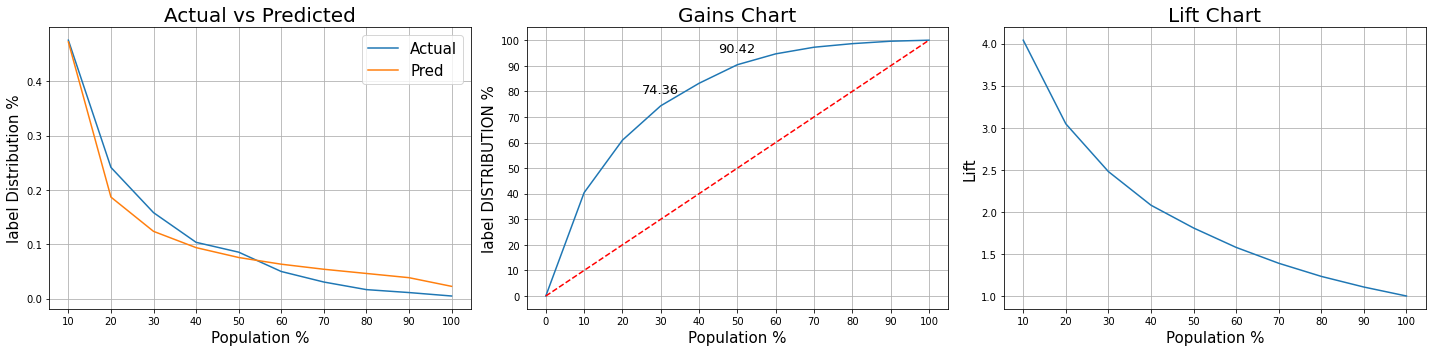

In [11]:
gains(pred_train, train_deciles, 'deciles', 'label','probability')

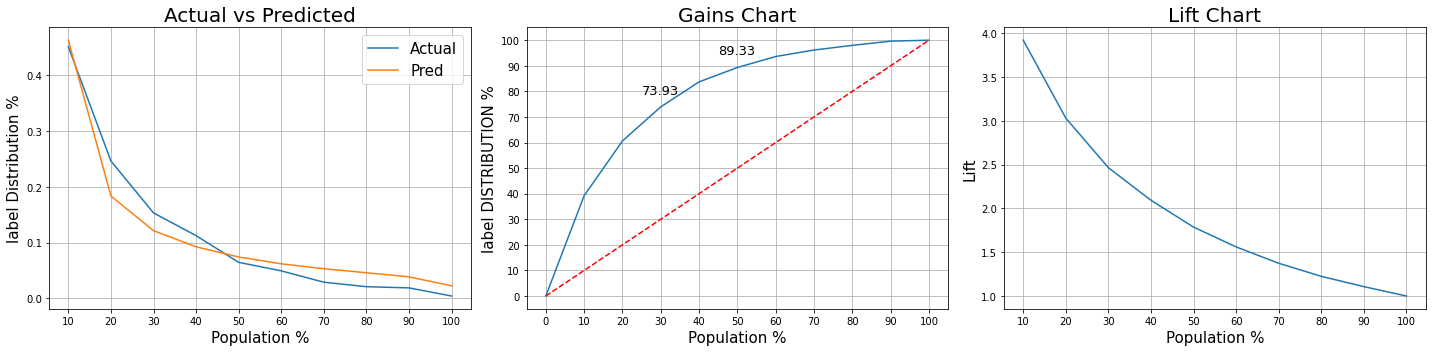

In [12]:
gains(pred_test, test_deciles, 'deciles', 'label','probability')